In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import sys
import logging
import pickle
import logging

# Data
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf

# Graph
import tensorflow_gnn as tfgnn

# Add the project root to the Python path
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.data_cleaner import filter_top_cpv_categories
#from scripts.gnn_anomaly_detection import ProcurementGraphBuilder, GNNAnomalyDetector, AnomalyAnalyzer
from scripts.gnn_anomaly_detection import ProcurementGraphBuilder, GNNAnomalyDetector, AnomalyAnalyzer, analyze_edge_anomaly_types

from scripts.synthetic_anomaly_generator import SyntheticAnomalyGenerator


%load_ext autoreload
%autoreload 2


2025-06-08 11:57:18.770085: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 11:57:18.779301: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 11:57:18.869291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-08 11:57:18.869358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-08 11:57:18.869504: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Configuration
DATA_PATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),
                        'data')
MODEL_PATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),
                            'models', 'anomalies')
os.makedirs(MODEL_PATH, exist_ok=True)

# Initialize components
graph_builder = ProcurementGraphBuilder()
gnn_detector = GNNAnomalyDetector(hidden_dim=64, output_dim=32,
                                    num_layers=3)
analyzer = AnomalyAnalyzer()

In [4]:
 # Load and preprocess data
X = graph_builder.load_data(DATA_PATH)
# Now using all three splits: train, val, test (with synthetic anomalies)
(X_train_preproc, X_val_preproc, X_test_preproc, 
    X_train, X_val, X_test) = graph_builder.preprocess_data(X)

# Create graphs for all three splits
X_train_graph = graph_builder.create_graph(X_train_preproc, X_train, type='train')
X_val_graph = graph_builder.create_graph(X_val_preproc, X_val, type='val')
X_test_graph = graph_builder.create_graph(X_test_preproc, X_test, type='test')

INFO:scripts.gnn_anomaly_detection:Loading data from /home/ronan/code/RonanB400/Project/decp_ml/data
INFO:scripts.gnn_anomaly_detection:Preprocessing data...


Filtered from 392 to 60 CPV categories, keeping 250895 rows out of 286850


/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
INFO:scripts.synthetic_anomaly_generator:Generating 5017 total synthetic anomaly rows
INFO:scripts.synthetic_anomaly_generator:Approximately 501 anomalies per type
INFO:scripts.synthetic_anomaly_generator:Generating single_bid_competitive anomalies...
INFO:scripts.synthetic_anomaly_generator:Generated 501 single bid competitive anomaly rows
INFO:scripts.synthetic_anomaly_generator:Generating price_inflation anomalies...
INFO:scripts.synthetic_anomaly_generator:Generated 501 price inflation anomaly rows
INFO:scripts.synthetic_anomaly_generator:Generating price_deflation anomalies...
INFO:scripts.synthetic_anomaly_generator:Generated 501 price deflation

In [8]:
# Scale derived node/edge features using training data
logger.info("Scaling derived node and edge features...")
node_features_train = X_train_graph['node_features']
edge_features_train = X_train_graph['edge_features']

# Fit scalers on training data (derived features)
node_features_train_scaled = graph_builder.node_scaler.fit_transform(
    node_features_train)
edge_features_train_scaled = graph_builder.edge_scaler.fit_transform(
    edge_features_train)

# Transform validation features using training scalers
node_features_val = X_val_graph['node_features']
edge_features_val = X_val_graph['edge_features']
node_features_val_scaled = graph_builder.node_scaler.transform(
    node_features_val)
edge_features_val_scaled = graph_builder.edge_scaler.transform(
    edge_features_val)

# Transform test features using training scalers
node_features_test = X_test_graph['node_features']
edge_features_test = X_test_graph['edge_features']
node_features_test_scaled = graph_builder.node_scaler.transform(
    node_features_test)
edge_features_test_scaled = graph_builder.edge_scaler.transform(
    edge_features_test)

# Create TensorFlow graphs for all three splits
X_train_tf_graph = gnn_detector.create_tensorflow_graph(
    X_train_graph, node_features_train_scaled, edge_features_train_scaled)
X_val_tf_graph = gnn_detector.create_tensorflow_graph(
    X_val_graph, node_features_val_scaled, edge_features_val_scaled)
X_test_tf_graph = gnn_detector.create_tensorflow_graph(
    X_test_graph, node_features_test_scaled, edge_features_test_scaled)

# Store graph tensors for later use
gnn_detector.graph_tensor_train = X_train_tf_graph
gnn_detector.graph_tensor_val = X_val_tf_graph
gnn_detector.graph_tensor_test = X_test_tf_graph

NameError: name 'logger' is not defined

# Edge anomalies

INFO:scripts.gnn_anomaly_detection:Building GNN model for edge anomaly detection...


INFO:scripts.gnn_anomaly_detection:Training edge GNN model for 100 epochs...


Epoch 1/100


1/1 [==============================] - 6s 6s/step - loss: 0.4589 - edge_embeddings_loss: 0.0640 - edge_reconstructed_loss: 0.5028 - val_loss: 0.1906 - val_edge_embeddings_loss: 0.4544 - val_edge_reconstructed_loss: 0.1613
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.4004 - edge_embeddings_loss: 0.0661 - edge_reconstructed_loss: 0.4375 - val_loss: 0.1757 - val_edge_embeddings_loss: 0.3992 - val_edge_reconstructed_loss: 0.1509
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.3694 - edge_embeddings_loss: 0.0682 - edge_reconstructed_loss: 0.4029 - val_loss: 0.1626 - val_edge_embeddings_loss: 0.3510 - val_edge_reconstructed_loss: 0.1417
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.3271 - edge_embeddings_loss: 0.0665 - edge_reconstructed_loss: 0.3561 - val_loss: 0.1531 - val_edge_embeddings_loss: 0.3147 - val_edge_reconstructed_loss: 0.1351
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.3001

/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this Stru

INFO:tensorflow:Assets written to: /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model/assets


INFO:tensorflow:Assets written to: /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model/assets
INFO:scripts.gnn_anomaly_detection:Edge model saved to /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model


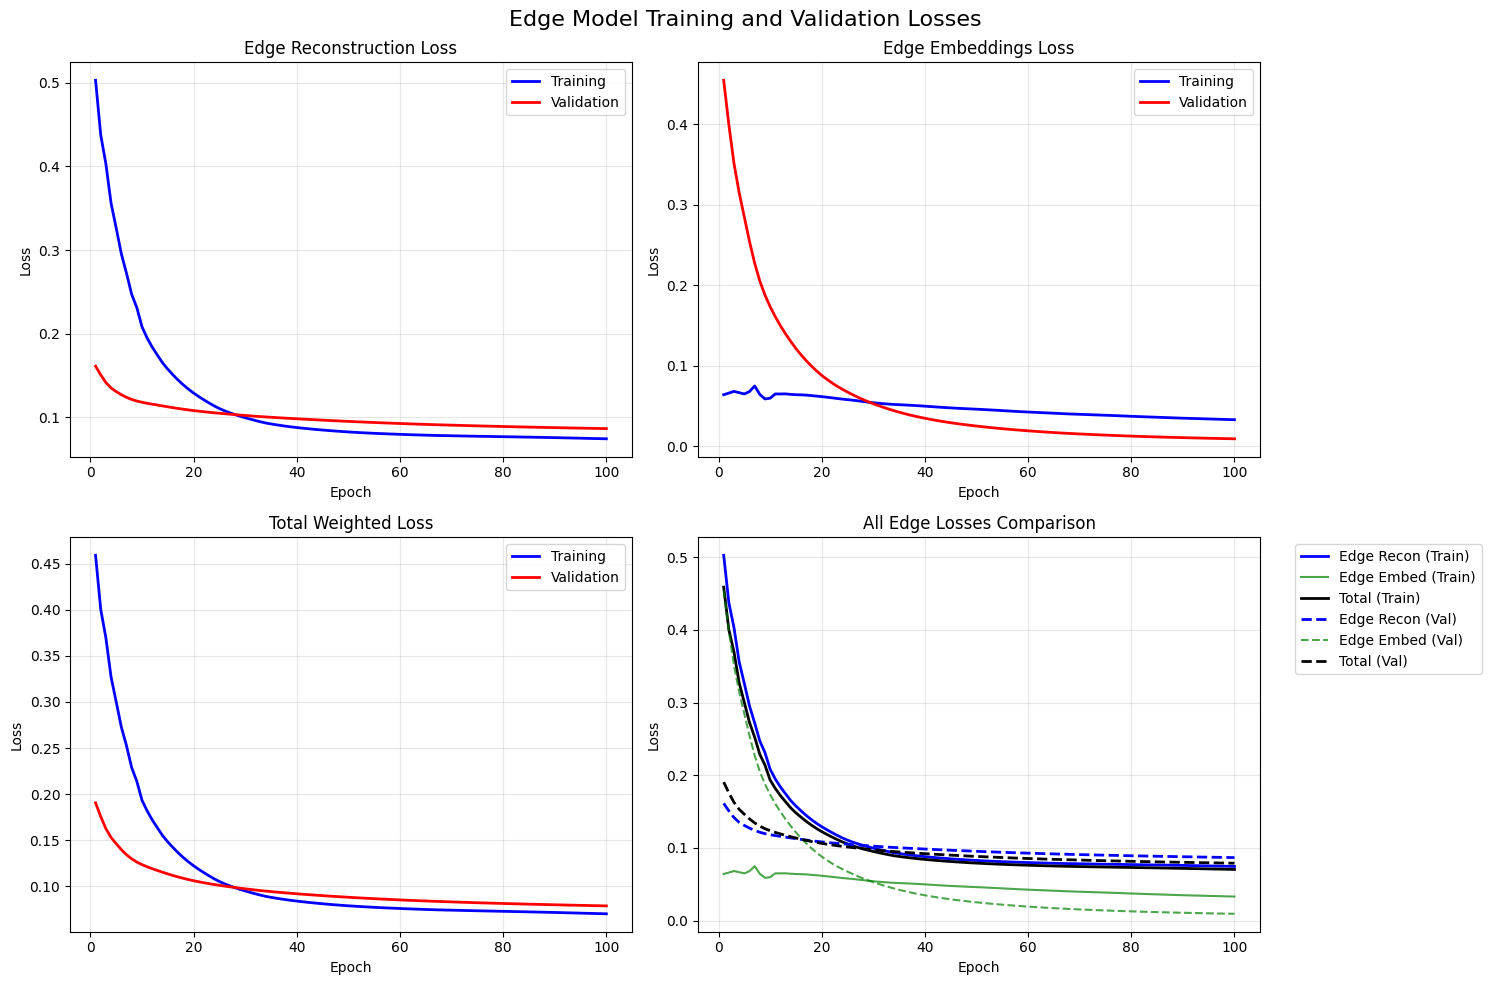


EDGE MODEL - FINAL LOSS VALUES
Training Losses (Final Epoch):
  - Edge Reconstruction: 0.074507
  - Edge Embeddings: 0.033011
  - Total Weighted Loss: 0.070357

Validation Losses (Final Epoch):
  - Edge Reconstruction: 0.086667
  - Edge Embeddings: 0.009281
  - Total Weighted Loss: 0.078928

Training vs Validation Analysis:
  - ✅ Good generalization (train ≈ val loss)


In [6]:
gnn_detector.edge_model = gnn_detector.build_edge_model(X_train_graph['node_features'].shape[1], X_train_graph['edge_features'].shape[1],
                                              l2_regularization=0, dropout_rate=0)

edge_history = gnn_detector.train_edge_model(X_train_tf_graph, 
                                        validation_graph_tensor=X_val_tf_graph, 
                                         epochs=100)

gnn_detector.plot_edge_training_history(edge_history)

In [ ]:
analyze_edge_anomaly_types(X_test_tf_graph)

# Node anomalies

In [ ]:
gnn_detector.node_model = gnn_detector.build_node_model(X_train_graph['node_features'].shape[1], X_train_graph['edge_features'].shape[1],
                                              l2_regularization=0, dropout_rate=0)

node_history = gnn_detector.train_node_model(X_train_tf_graph, 
                                        validation_graph_tensor=X_val_tf_graph, 
                                        epochs=50)

gnn_detector.plot_node_training_history(node_history)

In [ ]:

(node_reconstruction_error, edge_reconstruction_error, 
     node_threshold, edge_threshold) = gnn_detector.detect_anomalies()
    
# Calculate anomaly masks
node_anomalies = node_reconstruction_error > node_threshold
edge_anomalies = edge_reconstruction_error > edge_threshold

In [ ]:
 #Create results analysis
graph_data = X_test_graph

analyzer = AnomalyAnalyzer()

node_results_df = analyzer.create_node_results_dataframe(
    graph_data, node_reconstruction_error, node_anomalies)

node_results_df.head()

In [ ]:
edge_results_df = analyzer.create_edge_results_dataframe(
    graph_data, edge_reconstruction_error, edge_anomalies)

edge_results_df.head()

In [ ]:
data_path

In [ ]:
model_path = os.path.join(data_path, 'gnn_anomaly_model.keras')

tf.saved_model.save(gnn_detector.model, model_path)

In [ ]:
graph_builder = ProcurementGraphBuilder()
graph_builder.visualize_procurement_graph(X_train_graph)